# Toxicity Detection in Memes | EVA Application

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/toxicity-classification/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/toxicity-classification/blob/main/README.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="
    https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/README.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table>
<br>
<br>

### Install Application Dependecies 

In [9]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/requirements.txt"
!pip -q --no-color install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


### Start EVA server

We are reusing the start server notebook for launching the EVA server.

In [11]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/00-start-eva-server.ipynb"
%run 00-start-eva-server.ipynb
cursor = connect_to_server()

File '00-start-eva-server.ipynb' already there; not retrieving.

nohup eva_server > eva.log 2>&1 &

Note: you may need to restart the kernel to use updated packages.


### Load the Memes for analysis

In [12]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme1.jpg"
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/meme2.jpg"
cursor.execute('DROP TABLE IF EXISTS MemeImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "meme1.jpg" INTO MemeImages;')
response = cursor.fetch_all()
print(response)
cursor.execute('LOAD IMAGE "meme2.jpg" INTO MemeImages;')
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                                         0
0  Table Successfully dropped: MemeImages
@query_time: 0.04313108487986028
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.053857061080634594
@status: ResponseStatus.SUCCESS
@batch: 
                            0
0  Number of loaded IMAGE: 1
@query_time: 0.01734023983590305


### Create OCR Extractor UDF

In [13]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/ocr_extractor.py"
cursor.execute("DROP UDF OCRExtractor;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS OCRExtractor
      INPUT  (frame NDARRAY UINT8(3, ANYDIM, ANYDIM))
      OUTPUT (labels NDARRAY STR(ANYDIM), bboxes NDARRAY FLOAT32(ANYDIM, 4),
              scores NDARRAY FLOAT32(ANYDIM))
      TYPE  Classification
      IMPL  'ocr_extractor.py';
      """)
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.FAIL
@batch: 
 None
@error: UDF OCRExtractor does not exist, therefore cannot be dropped.
@status: ResponseStatus.SUCCESS
@batch: 
                                                       0
0  UDF OCRExtractor successfully added to the database.
@query_time: 5.707377003971487


### Create Custom UDF for Toxicity Classification

In [17]:
!wget -nc "https://raw.githubusercontent.com/georgia-tech-db/toxicity-classification/main/toxicity_classifier.py"
cursor.execute("DROP UDF IF EXISTS ToxicityClassifier;")
response = cursor.fetch_all()
print(response)
cursor.execute("""CREATE UDF IF NOT EXISTS ToxicityClassifier
                  INPUT  (text NDARRAY STR(100))
                  OUTPUT (labels NDARRAY STR(10))
                  TYPE  Classification
                  IMPL  'toxicity_classifier.py';
      """) 
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
 Empty DataFrame
Columns: []
Index: []
@query_time: 0.010849111014977098
@status: ResponseStatus.SUCCESS
@batch: 
                                                             0
0  UDF ToxicityClassifier successfully added to the database.
@query_time: 1.7548030819743872


### Run Toxicity Classifier on OCR Extracted from Images

In [18]:
cursor.execute("""SELECT OCRExtractor(data).labels,
                  ToxicityClassifier(OCRExtractor(data).labels)
                  FROM MemeImages;""")
response = cursor.fetch_all()
print(response)

@status: ResponseStatus.SUCCESS
@batch: 
                              ocrextractor.labels toxicityclassifier.labels
0                  [CANT FuCK WITh, MEIN SWAG E]                     toxic
1  [YOU CANT SPELL, CLINTON WITHOUT CNN, igfip:]                 not toxic
@query_time: 7.014302969910204


### Visualize Model Output on Images

In [64]:
from pprint import pprint
from matplotlib import pyplot as plt
import cv2
import numpy as np

def annotate_image(detections, input_image_path, image_id):

    print(detections)

    color1=(207, 248, 64)
    color2=(255, 49, 49)
    thickness=4

    df = detections
    df = df[df.index == image_id]

    image = cv2.imread(input_image_path)

    if df.size:
        df_value_list = df.values
        ocr = ' '.join(df_value_list[0][0])
        label = df_value_list[0][1]
        print(label)

        plt.imshow(image)
        plt.show()

        cv2.putText(image, label, (25, 200), cv2.FONT_HERSHEY_SIMPLEX, 3, color2, thickness, cv2.LINE_AA) 

        cv2.putText(image, ocr, (25, 250), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color1, thickness, cv2.LINE_AA) 

        plt.imshow(image)
        plt.show()        

                             ocrextractor.labels toxicityclassifier.labels
0                  [CANT FuCK WITh, MEIN SWAG E]                     toxic
1  [YOU CANT SPELL, CLINTON WITHOUT CNN, igfip:]                 not toxic
toxic


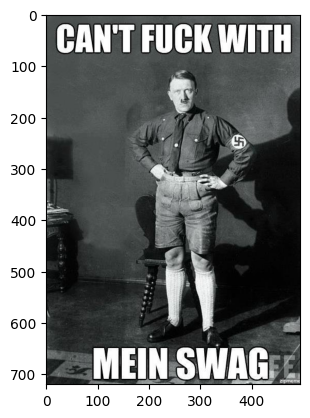

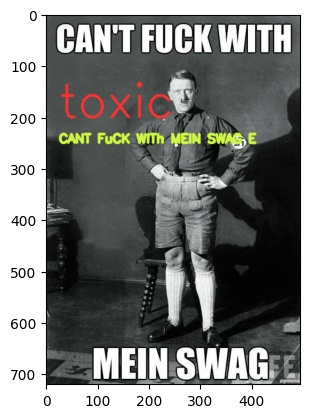

                             ocrextractor.labels toxicityclassifier.labels
0                  [CANT FuCK WITh, MEIN SWAG E]                     toxic
1  [YOU CANT SPELL, CLINTON WITHOUT CNN, igfip:]                 not toxic
not toxic


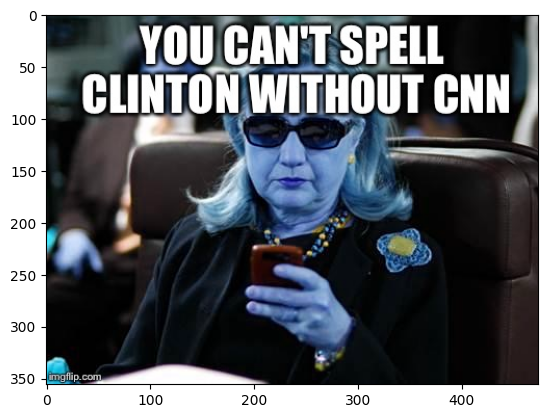

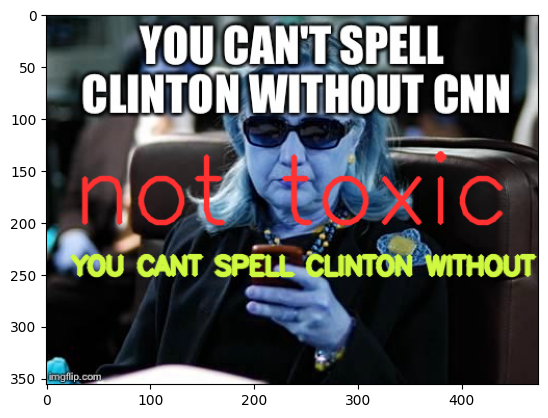

In [65]:
from ipywidgets import Image
dataframe = response.batch.frames
annotate_image(dataframe, 'meme1.jpg', image_id=0)
annotate_image(dataframe, 'meme2.jpg', image_id=1)